In [1]:
from __future__ import annotations

import time
from dataclasses import asdict, dataclass
from pathlib import Path
from typing import Literal

import jax
import jax.numpy as jnp
import liesel.goose as gs
import numpy as np
import optax
import pandas as pd
import torch
import veccs
from batram.legmods import Data, SimpleTM
from batram.stopper import EarlyStopper
from scipy import stats

import ppptm as gptm

torch.set_default_dtype(torch.float64)
jax.config.update("jax_enable_x64", True)


/Users/johannesbrachem/Documents/git/ppptm/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ----------------------------------------------------------------------------------
# General settings
# ----------------------------------------------------------------------------------


@dataclass
class Config:
    # job settings
    test: bool = False

    # general model settings
    nlocs: int = -1
    ntrain: int = 20
    ntest: int = 18
    nvalidation: int = 0
    split_seed: int = 1
    m: int = 256  # number of inducing locations
    locs_3d: bool = True

    # marginal model settings
    G_dist: Literal["gaussian1", "gaussian2", "skewt", "gamma", "weibull"] = "gaussian1"
    G_ard: bool = True

    H: bool = True
    H_a: float = -4.0
    H_b: float = 4.0
    H_nparam: int = 40
    H_ard: bool = False
    H_locwise_amplitude: bool = False

    HG_niter: int = 2000
    HG_init_lr: float = 0.01
    HG_patience: int = 10
    HG_tol: float = 0.3
    HG_opt: Literal["adamw", "rmsprop"] = "adamw"

    # transport map settings
    T_niter: int = 1000
    T_init_lr: float = 0.01
    T_patience: int = 10
    T_tol: float = 0.3
    T_batch_size: int | None = 0
    T_opt: Literal["adam", "rmsprop", "lbfgs"] = "rmsprop"

    THG_preprocess: Literal["train", "all-obs", "none", "all-locs"] = "none"

    def __post_init__(self):
        self.ntest = self.ntest - self.nvalidation
        self.T_batch_size = self.T_batch_size if self.T_batch_size > 0 else None

    def save(self, data: dict, path: str | Path) -> pd.DataFrame:
        data_and_config = data | asdict(self)

        df = pd.DataFrame(data_and_config, index=pd.Index([0]))
        df.to_csv(path, index=False)
        self.mark_as_finished()
        return df


In [3]:
config = Config()


In [4]:
# ----------------------------------------------------------------------------------
# Data import
# ----------------------------------------------------------------------------------

data = gptm.load_americas()

locs = gptm.LocationVars.new_from(
    data.locs, n_subset=config.m, from_2d_to_3d=config.locs_3d
)
y = data.obs[:, locs.locs.ordering]


In [5]:
# ----------------------------------------------------------------------------------
# Data pre-processing
# ----------------------------------------------------------------------------------
rng = np.random.default_rng(config.split_seed)
rng.shuffle(y, axis=0)


if config.nlocs == -1:
    nlocs = 2738

y_model = y[..., : config.nlocs]
locs_model = locs.locs.ordered[: config.nlocs, ...]

locs.ordered.value = locs.locs.ordered[: config.nlocs, ...]

train, validate, test = (
    y_model[: config.ntrain, :],
    y_model[-(config.ntest + config.nvalidation) : -config.ntest, :],
    y_model[-config.ntest :, :],
)

if config.nvalidation == 0:
    validate = train

if config.G_dist in ["gamma", "weibull"]:
    config.THG_preprocess = "none"

match config.THG_preprocess:
    case "train":
        train_means = train.mean(axis=0, keepdims=True)
        train_sds = train.std(axis=0, keepdims=True)
    case "all-obs":
        train_means = y_model.mean(axis=0, keepdims=True)
        train_sds = y_model.std(axis=0, keepdims=True)
    case "all-locs":
        train_means = y_model.mean(keepdims=True)
        train_sds = y_model.std(keepdims=True)
    case "none":
        train_means = 0.0
        train_sds = 1.0

train = (train - train_means) / train_sds
validate = (validate - train_means) / train_sds
test = (test - train_means) / train_sds

logdet_addition = -jnp.log(train_sds)


In [6]:
# ----------------------------------------------------------------------------------
# Marginal model
# ----------------------------------------------------------------------------------

# set up G

match config.G_dist:
    case "gaussian1":
        G = gptm.G(train, locs, ard=config.G_ard)
        g = G.new_gaussian()
        locscale = True
    case "gaussian2":
        G = gptm.G(train, locs, ard=config.G_ard)
        g = G.new_gaussian(locwise=[])
        locscale = True
    case "skewt":
        G = gptm.G(train, locs, ard=config.G_ard)
        g = G.new_skewt()
        locscale = False
    case "gamma":
        train = jnp.exp(train)
        validate = jnp.exp(validate)
        test = jnp.exp(test)
        G = gptm.G(train, locs, ard=config.G_ard)
        g = G.new_gamma()
        locscale = False
        logdet_addition = logdet_addition + jnp.log(test)
    case "weibull":
        train = jnp.exp(train)
        validate = jnp.exp(validate)
        test = jnp.exp(test)
        G = gptm.G(train, locs, ard=config.G_ard)
        g = G.new_weibull()
        locscale = False
        logdet_addition = logdet_addition + jnp.log(test)


# set up H
h = gptm.H(
    locs,
    ard=config.H_ard,
    locwise_amplitude=config.H_locwise_amplitude,
).new_coef()

# set up model
if config.H:
    marginal_model = gptm.Model.new_HG(
        train,
        locs,
        g_dist=g,
        coef=h,
        locscale=locscale,
        a=config.H_a,
        b=config.H_b,
        nparam=config.H_nparam,
    )
else:
    marginal_model = gptm.Model.new_G(train, locs, g, locscale=locscale)


# fit model
scheduler = optax.cosine_decay_schedule(
    init_value=config.HG_init_lr, decay_steps=config.HG_niter
)
match config.HG_opt:
    case "adamw":
        hg_opt = optax.adamw(learning_rate=scheduler, weight_decay=1e-4)
    case "rmsprop":
        hg_opt = optax.rmsprop(learning_rate=scheduler)

gradient_clipping = optax.clip_by_global_norm(1.0)
marginal_opt = optax.chain(gradient_clipping, hg_opt)

start = time.time()
result = marginal_model.fit(
    stopper=gs.Stopper(
        max_iter=config.HG_niter, patience=config.HG_patience, atol=config.HG_tol
    ),
    response_validation=validate if config.nvalidation > 0 else None,
    optimizer=marginal_opt,
    progress_bar=True,
)
end = time.time()

time_hg = end - start

train_hg = marginal_model.hg(train)
validate_hg = marginal_model.hg(validate)
test_hg = marginal_model.hg(test)


Training loss: 90750.063, Validation loss: 90750.063:   8%|▊         | 159/2000 [00:08<01:21, 22.69it/s]  

In [7]:
# ----------------------------------------------------------------------------------
# Dependence Model
# ----------------------------------------------------------------------------------

tloc = torch.tensor(np.asarray(locs_model, dtype=np.float64), dtype=torch.float64)

# Finding nearest neighbors using the `veccs` package.
# The computation time of the model scales as a function of the condition set
# size. We recommend restricting this to be no larger than 30 neighbors.
largest_conditioning_set = 30

nn, _ = veccs.preceding_neighbors(
    coordinates=np.asarray(locs_model, dtype=np.float64),
    sequence=np.arange(locs_model.shape[0]),
    num_neighbors=largest_conditioning_set,
)

tnn = torch.as_tensor(nn, dtype=torch.int64)

train_data = Data.new(tloc, torch.tensor(train_hg, dtype=torch.float64), tnn)
validate_data = Data.new(tloc, torch.tensor(validate_hg, dtype=torch.float64), tnn)

tm = SimpleTM(
    train_data,
    theta_init=None,
    linear=False,
    smooth=1.5,
    nug_mult=4.0,
)

tm.double()

stopper = EarlyStopper(patience=config.T_patience, min_diff=config.T_tol)
match config.T_opt:
    case "adam":
        opt = torch.optim.Adam(tm.parameters(), lr=config.T_init_lr)
    case "rmsprop":
        opt = torch.optim.RMSprop(tm.parameters(), lr=config.T_init_lr)
    case "lbfgs":
        opt = torch.optim.LBFGS(
            tm.parameters(), lr=config.T_init_lr, line_search_fn="strong_wolfe"
        )
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, config.T_niter)

start = time.time()
res = tm.fit(
    num_iter=config.T_niter,
    init_lr=config.T_init_lr,
    test_data=validate_data,
    optimizer=opt,
    stopper=stopper,
    batch_size=config.T_batch_size,
    scheduler=sched,
)
end = time.time()

time_t = end - start


Train Loss: -18137.101, Test Loss: -18137.381:  60%|██████    | 601/1000 [00:56<00:37, 10.63it/s]69it/s]


In [8]:
# ----------------------------------------------------------------------------------
# Log Scores
# ----------------------------------------------------------------------------------
def compute_log_score(obs, marginal: gptm.Model, dependence: SimpleTM):
    mdist = marginal.init_dist()
    obs_hg, obs_hg_logdet = mdist.transformation_and_logdet(obs)
    obs_hg_logdet = obs_hg_logdet + logdet_addition

    z, t_logdet = dependence.map_and_logdet(torch.tensor(obs_hg, dtype=torch.float64))
    z = z.detach().numpy()
    t_logdet = t_logdet.detach().numpy()

    log_prob = stats.norm.logpdf(z) + obs_hg_logdet + t_logdet
    log_prob = log_prob.sum(axis=1)
    log_score = -log_prob.mean()
    return log_score


log_score = compute_log_score(test, marginal_model, tm)

out = {
    "log_score": log_score,
    "time_hg": time_hg,
    "time_t": time_t,
}

/Users/johannesbrachem/Documents/git/ppptm/.venv/lib/python3.13/site-packages/batram/legmods.py:977: UserWarning: Negative v(y_1:i-1) clipped to zero.


In [9]:
def draw_sample(
    seed: int, n: int, marginal: gptm.Model, dependence: SimpleTM
) -> jax.Array:
    locs_model = marginal.locs.ordered.value
    z = jax.random.normal(key=jax.random.key(seed), shape=(n, locs_model.shape[0]))

    with torch.no_grad():
        zt = dependence.inverse_map(torch.tensor(np.asarray(z)), sample_nugget=True)
        zt = zt.numpy()

    y = marginal.hgi(zt)

    return y


y_new = draw_sample(seed=1, n=1, marginal=marginal_model, dependence=tm)
locs_2d = data.locs[locs.locs.ordering, ...][: config.nlocs, ...]
sample_df = gptm.long_df(locs_2d, y_new)
sample_df

,loc,lon,lat,obs,value
0,0,272.50,5.183246,0,-16.405203
1,1,250.00,-29.685864,0,-16.814032
2,2,295.00,-29.685864,0,-22.804630
3,3,250.00,39.109948,0,-16.419118
4,4,295.00,39.109948,0,-21.837731
...,...,...,...,...,...
2732,2732,287.50,36.282723,0,-24.032788
2733,2733,288.75,36.282723,0,-23.938052
2734,2734,290.00,36.282723,0,-23.147132
2735,2735,291.25,36.282723,0,-23.265767


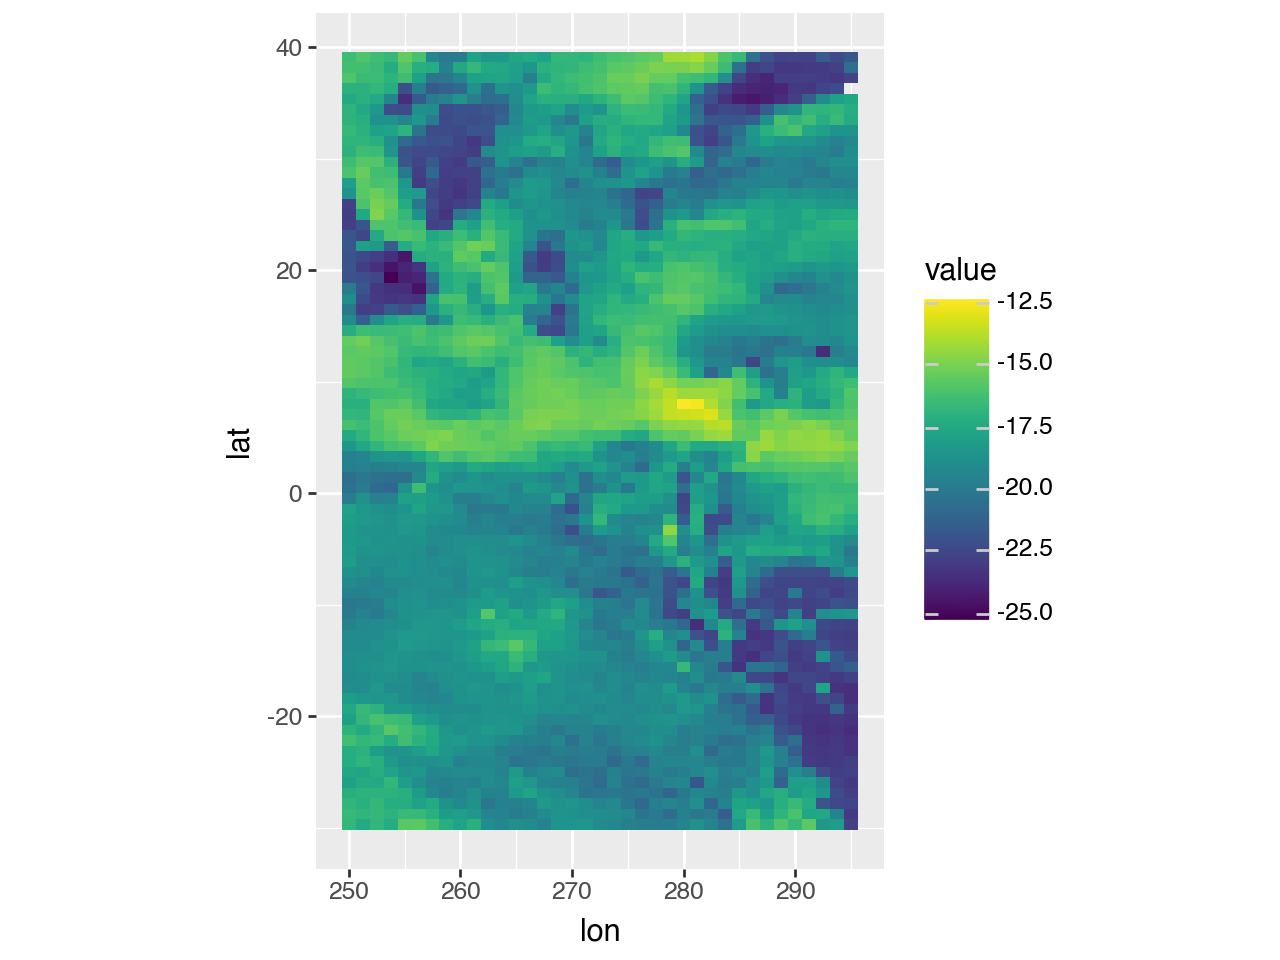

In [10]:
gptm.plot_df(sample_df)

In [11]:
# uncommment and define path to save data
# config.save(data, path=...)